In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from Models import ConvEncoder, ConvDecoder, mlpEncoder, mlpDecoder, TrAE, Classifier, TrLSTM, TrLinear
from Dataset import data_provider, Trajectory2Dset

from torch.utils.data import DataLoader

import time
import copy
from tqdm import tqdm

Need to code for evaluating using accuracy, F1 score, AUROC, AUPRC of classification, and loss value of AE

In [2]:
import easydict

args = easydict.EasyDict({
    'is_training': 1,
    'model': 'A', # ['A', 'B']
    ### data loader
    'root_path': './Data/',
    'data': '2D/', # ['2D', '3D/old/', '3D/new/']
    'data_path': 'csv/',
    'data_type': 'normal', # ['noraml', 'mixed']
    'checkpoints': './checkpoints/',
    'Nsamples': 500, 
    'ratio': [7,1,2],
    ### forecasting task
    'seq_len': 2651, # [2144, 4576, 2651] # 3200 in paper
    'label_len': 100,
    'pred_len': 100,
    'class_num': 5,
    'individual': False,
    ### transformer
    'layer_num': 1,
    'dropout': 0.1,
    'max_len': 5000,
    'd_model': 512,
    'd_h': 8,
    'd_ff': 2048,
    ### Layers
    'layer_num': 5,
    'input_channel': 23,    # 2 in paper
    't': 128,               # 16 in paper
    'output_channel': 23,   # 4 in paper
    'do_predict': True,
    ### optimization
    'num_workers': 8,
    'itr': 1,
    'train_epochs': 1000,   # 1000 in paper
    'batch_size': 64,       # 64 in paper
    'patience': 3,
    'lr': 0.005,
    ### GPU
    'device': 'cuda:0',
    'use_gpu': True,
    'multi_gpu': True,
})

args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if args.data == '2D/':
    args.data_path = ''
    args.seq_len = 3200  # 3200 in paper
    args.class_num = 4
    args.input_channel = 2
    args.t = 16
    args.output_channel = 4
    args.ratio = [3,1,1]
elif args.data == '3D/old/':
    args.data_path = ''
    args.seq_len = 4576
    args.input_channel = 3
    args.t = 64
    args.output_channel = 8
elif args.data == '3D/new/':
    args.input_channel = 3 # [3, 3, 3, 3, 3, 4, 4]
    args.seq_len = 3200  # 3200 in paper
    args.t = 16

if args.model == 'B':
    args.seq_len = 400
print(args.device)

cuda:0


## Data Preprocessing

### 2-Dimensional Trajectory

원본 .pickle 로드 및 전처리 후 .npy 저장

In [2]:
import pickle
'''
Trajectory types: Normal, autopilot_lag, LOSrate_bias, LOSrate_delay
Target distance = uniform(4500, 5500)
states = [x, y, vm, path_angle] + 1 control input, 5 states
label = 0, 1, 2, 3 for normal, autopilot_lag, LOSrate_bias, LOSrate_delay respectively, 4 classes
minimum length of trajectory = 1360 (1360*0.01 = 13.6 seconds)
maximum length of trajectory = 2131 (2131*0.01 = 21.31 seconds)
fixed sequence length = 2144 (2144*0.01 = 21.44 seconds)
'''
start = time.time()
with open('Data/2D/Trajectories.pickle', 'rb') as f:
    Dataset = pickle.load(f)

# normal = Dataset['normal_PNG']
# lag = Dataset['autopilot_lag']
# bias = Dataset['LOSrate_bias']
# delay = Dataset['LOSrate_delay']
seq_len = 2144

label = 0
x = []
y = []
for tr_type in Dataset:
    states = Dataset[tr_type]['states']
    inputs = Dataset[tr_type]['actions']
    for i in range(len(states)):
        tr = np.concatenate((states[i], np.insert(inputs[i], 0, 0).reshape(-1 ,1)), axis=1)
        terminal = tr[-1].copy()
        terminal[2]=terminal[4]=0
        tr = np.concatenate((tr, np.tile(terminal, (seq_len-len(tr), 1))), axis=0)
        x.append(tr)
        y.append(label)
    label += 1
x = np.array(x)
y = np.array(y).reshape(-1, 1)
np.save('Data/2D/x.npy', x)
np.save('Data/2D/y.npy', y)
# x = np.load('Data/2D/x.npy')
# y = np.load('Data/2D/y.npy')
x.shape, y.shape, time.time()-start

((2000, 2144, 5), (2000, 1), 0.24863266944885254)

.npy 로드

In [43]:
x = np.load('Data/2D/x.npy')
y = np.load('Data/2D/y.npy')
x.shape, y.shape, time.time()-start

((2000, 2144, 5), (2000, 1), 4.354981899261475)

### 3-Dimentional Trajectory old version

원본 .pickle 로드 및 전처리 후 .npy 저장

In [5]:
'''
Trajectory types: Normal, Burn time, Xcp position, Thrust Tilt Angle, Fin bias
Target Distance = 4000
States = ['Accm_1', 'Accm_2', 'Accm_3', 'angEuler_1', 'angEuler_2', 'angEuler_3', 'Rmi_1', 'Rmi_2', 'Rmi_3', 'Vmi_1', 'Vmi_2', 'Vmi_3', 'Accm_Cmd_1', 'Accm_Cmd_2', 'Accm_Cmd_3', 'PhiCmd'], 16 states
label = [0, 1, 2, 3, 4] for normal, burn_time, xcp_pos, thrust_tilt, fin_bias respectively, 5 classes
minimum length of trajectory = 412 (412*0.01 = 4.12 seconds)
maximum length of trajectory = 4569 (4569*0.01 = 45.69 seconds)
fixed sequence length = 4576 (4576*0.01 = 45.76 seconds)
'''
start = time.time()
seq_len = 4576
x = []
y = []

for i, tr_type in enumerate(['Normal', 'Burntime', 'Xcpposition', "ThrustTiltAngle", 'Finbias']):
    gid = pd.read_excel(f'Data/3D/old/Gid_{i+1}.xlsx', sheet_name=None)
    msl = pd.read_excel(f'Data/3D/old/Msl_{i+1}.xlsx', sheet_name=None)
    
    for sheet in gid:
        tr = pd.merge(msl[sheet][['Time', 'Rmi_1', 'Rmi_2', 'Rmi_3', 'Vmi_1', 'Vmi_2', 'Vmi_3', 'Accm_1', 'Accm_2', 'Accm_3', 'angEuler_1', 'angEuler_2', 'angEuler_3']], gid[sheet][['Time', 'Accm_Cmd_1', 'Accm_Cmd_2', 'Accm_Cmd_3', 'Phi_Cmd']]).to_numpy()[:, 1:]
        terminal = tr[-1].copy()
        terminal[3]=terminal[4]=terminal[5]=terminal[6]=terminal[7]=terminal[8]=terminal[12]=terminal[13]=terminal[14]=terminal[15]=0
        tr = np.concatenate((tr, np.tile(terminal, (seq_len-len(tr), 1))), axis=0)
        if sheet == 'Sheet1' and tr_type == 'Normal':
            x = [tr for _ in range(140)]
            y = [i for _ in range(140)]
        else:
            x.append(tr)
            y.append(i)

x = np.array(x)
y = np.array(y).reshape(-1, 1)
np.save('Data/3D/x_old.npy', x)
np.save('Data/3D/y_old.npy', y)
# x = np.load('Data/3D/x_old.npy')
# y = np.load('Data/3D/y_old.npy')
x.shape, y.shape, time.time()-start

((700, 4576, 16), (700, 1), 438.2133049964905)

.npy 로드

In [42]:
start = time.time()
x = np.load('Data/3D/x_old.npy')
y = np.load('Data/3D/y_old.npy')
x.shape, y.shape, time.time()-start

((700, 4576, 16), (700, 1), 0.07254505157470703)

### 3-Dimensional Trajectory new version

원본 .pickle 로드 및 전처리 후 .npy 저장

In [128]:
'''
Trajectory types: Normal, Burn time, Xcp position, Thrust Tilt Angle, Fin bias
Target Distance = 4000
Total states = ['Rmi_1', 'Rmi_2', 'Rmi_3', 'Vmi_1', 'Vmi_2', 'Vmi_3', 'Wmb_1', 'Wmb_2', 'Wmb_3', 'Accm_1', 'Accm_2', 'Accm_3', 'angEuler_1', 'angEuler_2', 'angEuler_3', 'FinOut_1', 'FinOut_2', 'FinOut_3', 'FinOut_4', 'err_FinBias_1', 'err_FinBias_2', 'err_FinBias_3', 'err_FinBias_4', 'FinCmd_1', 'FinCmd_2', 'FinCmd_3', 'FinCmd_4', 'err_BurnTime', 'err_Tilt_1', 'err_Tilt_2', 'err_delXcp'], 31 states
Used States = ['Rmi_1', 'Rmi_2', 'Rmi_3', 'Vmi_1', 'Vmi_2', 'Vmi_3', 'Wmb_1', 'Wmb_2', 'Wmb_3', 'Accm_1', 'Accm_2', 'Accm_3', 'angEuler_1', 'angEuler_2', 'angEuler_3', 'FinOut_1', 'FinOut_2', 'FinOut_3', 'FinOut_4', 'FinCmd_1', 'FinCmd_2', 'FinCmd_3', 'FinCmd_4'], 23 states
label = [0, 1, 2, 3, 4] for normal, burn_time, xcp_pos, thrust_tilt, fin_bias respectively, 5 classes
minimum length of trajectory = 2449 (2448*0.01 = 24.48 seconds)
maximum length of trajectory = 2635 (2635*0.01 = 26.35 seconds)
fixed sequence length = 2651 (2651*0.01 = 26.51 seconds)
    - before guidance : 96 (0 to 96 seconds)
    - initial guidance : 352 (80 to 432 seconds)
    - terminal guidance : 2240 (411 to 2651 seconds)
'''
start = time.time()
seq_len = 2656
x = []
y = []
tr = {}
for i, tr_type in enumerate(['Normal', 'Burntime', 'Xcpposition', "ThrustTiltAngle", 'Finbias']):
    N = 1 if i == 0 else 500
    for tr_i in range(N):
        tr = pd.read_csv(f'Data/3D/new/csv/Type_{i+1}_{tr_i+1}.csv', header=None)
        tr.columns = ['Rmi_1', 'Rmi_2', 'Rmi_3', 'Vmi_1', 'Vmi_2', 'Vmi_3', 'Wmb_1', 'Wmb_2', 'Wmb_3', 'Accm_1', 'Accm_2', 'Accm_3', 'angEuler_1', 'angEuler_2', 'angEuler_3', 'FinOut_1', 'FinOut_2', 'FinOut_3', 'FinOut_4', 'err_FinBias_1', 'err_FinBias_2', 'err_FinBias_3', 'err_FinBias_4', 'FinCmd_1', 'FinCmd_2', 'FinCmd_3', 'FinCmd_4', 'err_BurnTime', 'err_Tilt_1', 'err_Tilt_2', 'err_delXcp']
        tr = tr[['Rmi_1', 'Rmi_2', 'Rmi_3', 'Vmi_1', 'Vmi_2', 'Vmi_3', 'Wmb_1', 'Wmb_2', 'Wmb_3', 'Accm_1', 'Accm_2', 'Accm_3', 'angEuler_1', 'angEuler_2', 'angEuler_3', 'FinOut_1', 'FinOut_2', 'FinOut_3', 'FinOut_4', 'FinCmd_1', 'FinCmd_2', 'FinCmd_3', 'FinCmd_4']].to_numpy()
        tr[0] = 4000 - tr[0]
        terminal = tr[-1].copy()
        terminal[3]=terminal[4]=terminal[5]=terminal[6]=terminal[7]=terminal[8]=terminal[12]=terminal[13]=terminal[14]=terminal[19]=terminal[20]=terminal[21]=terminal[22]=0
        tr = np.concatenate((tr, np.tile(terminal, (seq_len-len(tr), 1))), axis=0)
        if i == 0:
            x = [tr for _ in range(500)]
            y = [i for _ in range(500)]
        else:
            x.append(tr)
            y.append(i)

x = np.array(x)
y = np.array(y).reshape(-1, 1)
np.save('Data/3D/x_new.npy', x)
np.save('Data/3D/y_new.npy', y)
# x = np.load('Data/3D/x_new.npy')
# y = np.load('Data/3D/y_new.npy')
x.shape, y.shape, time.time()-start

((2500, 2656, 23), (2500, 1), 16.053280115127563)

.npy 로드

In [6]:
start = time.time()
x = np.load('Data/3D/x_new.npy')
y = np.load('Data/3D/y_new.npy')
x.shape, y.shape, time.time()-start

((2500, 2656, 23), (2500, 1), 0.24094510078430176)

## Dataset and Network Load

In [3]:
train_set, train_loader = data_provider(args, 'train')
train_c_set, train_c_loader = data_provider(args, 'train_c')
valid_set, valid_loader = data_provider(args, 'valid')
test_set, test_loader = data_provider(args, 'test')
total_set, total_loader = data_provider(args, 'pred')
# next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape, len(train_loader), train_set.data_x.shape, train_set.data_y.shape
# next(iter(valid_loader))[0].shape, next(iter(valid_loader))[1].shape, len(valid_loader), valid_set.data_x.shape, valid_set.data_y.shape
# next(iter(test_loader))[0].shape, next(iter(test_loader))[1].shape, len(test_loader), test_set.data_x.shape, test_set.data_y.shape

In [11]:
model = TrAE(ConvEncoder, ConvDecoder, args).to(args.device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr)

## Training Script

In [9]:
def AE_train(model, dataloaders, criterion, optimizer, scheduler, num_epochs=10, channel_type = None, phase = None):
    """
    model: model to train
    dataloaders: train, val, test data's loader
    criterion: loss function
    optimizer: optimizer to update your model
    """
    if phase == 'before':
        tl = 0
    elif phase == 'initial':
        tl = 80
    elif phase == 'final':
        tl = 411
    else:
        tl = 0
    tr = tl + args.seq_len
    
    if channel_type == 'Rmi':
        cl = 0
    elif channel_type == 'Vmi':
        cl = 3
    elif channel_type == 'Wmb':
        cl = 6
    elif channel_type == 'Accm':
        cl = 9
    elif channel_type == 'ang':
        cl = 12
    elif channel_type == 'Fout':
        cl = 15
    elif channel_type == 'Fcmd':
        cl = 19
    else:
        cl = 0
    cr = cl + args.input_channel

    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = 99999999
    
    since = time.time()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()            # Set model to training mode
            else:
                model.eval()            # Set model to evaluate mode
                
            running_loss = 0.0
            # Iterate over data.
            for inputs, _ in dataloaders[phase]:
                inputs = inputs.to(args.device)[:,tl:tr,cl:cr].type(torch.float32).transpose(1, 2)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs, _ = model(inputs)
                    loss = criterion(outputs, inputs)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    scheduler.step()

                running_loss += loss.item()
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            
            # deep copy the model
            if phase == 'train':
                train_loss_history.append(epoch_loss)
            else:
                val_loss_history.append(epoch_loss)
                
            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_val_loss))

    # load best model weights
    # model.load_state_dict(best_model_wts)
    return model, best_model_wts, train_loss_history, val_loss_history

In [3]:
def train(model, Loss, optimizer, scheduler, num_epochs, phase = None, channel_type = None):
    if phase == 'before':
        tl = 0
    elif phase == 'initial':
        tl = 80
    elif phase == 'final':
        tl = 411
    else:
        tl = 0
        phase = 'whole'
    tr = tl + args.seq_len
    
    if channel_type == 'Rmi':
        cl = 0
    elif channel_type == 'Vmi':
        cl = 3
    elif channel_type == 'Wmb':
        cl = 6
    elif channel_type == 'Accm':
        cl = 9
    elif channel_type == 'ang':
        cl = 12
    elif channel_type == 'Fout':
        cl = 15
    elif channel_type == 'Fcmd':
        cl = 19
    else:
        cl = 0
        channel_type = 'position'
    cr = cl + args.input_channel
    
    print(f'{phase} phase {channel_type} data model training Start')
    
    train_loss_arr = []
    val_loss_arr = []

    best_val_loss = 99999999

    for epoch in tqdm(range(num_epochs), total=num_epochs, desc=f'Training', ncols=70):

        epoch_loss = 0.
        for batch_X, _ in train_loader:
      
            batch_X = batch_X.to(args.device)[:,:,:2].type(torch.float32).transpose(1, 2)
            optimizer.zero_grad()

            # Forward Pass
            model.train()
            outputs, _ = model(batch_X)
            train_loss = Loss(outputs, batch_X)
            epoch_loss += train_loss.data

            # Backward and optimize
            train_loss.backward()
            optimizer.step()
            scheduler.step()

        train_loss_arr.append((epoch_loss.item() / len(train_loader.dataset))/args.seq_len)

        model.eval()

        val_loss = 0.

        for batch_X, _ in valid_loader:
            batch_X = batch_X.to(args.device)[:,:,:2].type(torch.float32).transpose(1, 2)

            # Forward Pass
            outputs, _ = model(batch_X)
            batch_loss = Loss(outputs, batch_X)
            val_loss += batch_loss.data

        val_loss_arr.append((val_loss.item() / len(train_loader.dataset))/args.seq_len)

        if best_val_loss > val_loss:
            best_val_loss = val_loss
            # best_model_wts = copy.deepcopy(model.module.state_dict())
            best_model_wts = copy.deepcopy(model.state_dict())
    print('Train Loss: {:.4f}, Valid Loss: {:.4f}, Best Valid Loss: {:.4f}'.format(epoch_loss/args.seq_len, val_loss/args.seq_len, best_val_loss/args.seq_len))
    return model, best_model_wts, train_loss_arr, val_loss_arr

whole phase position data model training Start


Training: 100%|███████████████████| 1000/1000 [19:45<00:00,  1.19s/it]

Train Loss: 22.3555, Valid Loss: 7.7018, Best Valid Loss: 0.0780
model saved to ./checkpoints/2D/A_mixed_model


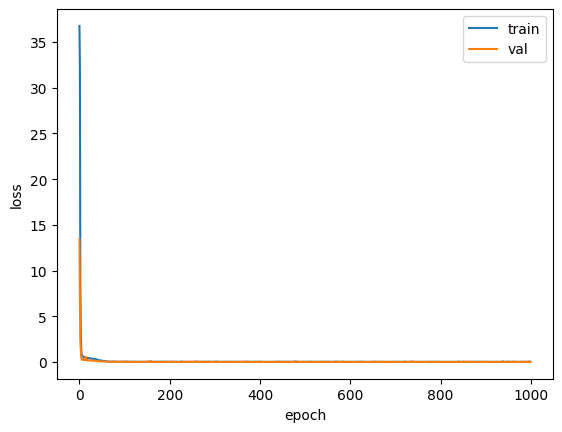

whole phase position data model training Start


Training: 100%|███████████████████| 1000/1000 [20:43<00:00,  1.24s/it]

Train Loss: 3.5806, Valid Loss: 1.4547, Best Valid Loss: 0.7867
model saved to ./checkpoints/2D/A_normal_model


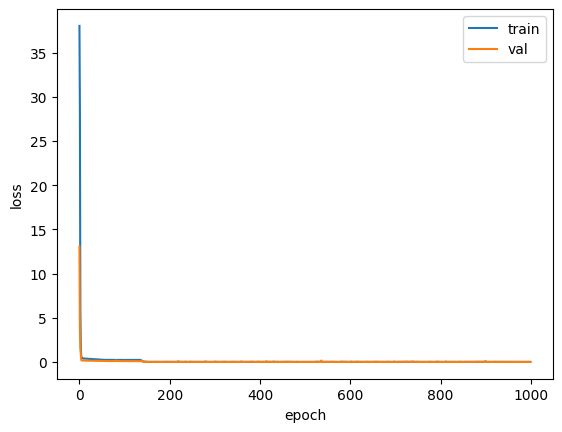

In [4]:
for dataT in ['mixed', 'normal']:
    # if dataT == 'normal':
    #     continue
    args.data_type = dataT
    train_set, train_loader = data_provider(args, 'train')
    train_c_set, train_c_loader = data_provider(args, 'train_c')
    valid_set, valid_loader = data_provider(args, 'valid')
    test_set, test_loader = data_provider(args, 'test')
    total_set, total_loader = data_provider(args, 'pred')
    
    if args.data == '3D/new':
        for phase in ['before', 'initial', 'final']:
            phase2len = {'before':96, 'initial':352, 'final':2240}
            args.seq_len = phase2len[phase]
            for chT in ['Rmi', 'Vmi', 'Wmi', 'Accm', 'Ang', 'Fout', 'Fcmd']:
                ch = {'Rmi':3, 'Vmi':3, 'Wmi':3, 'Accm':3, 'Ang':3, 'Fout':4, 'Fcmd':4}
                args.input_channel = ch[chT]
                model = TrAE(ConvEncoder, ConvDecoder, args).to(args.device)
                # model = torch.nn.DataParallel(model)
                criterion = nn.MSELoss()
                optimizer = optim.Adam(model.parameters(), lr=args.lr)
                scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)

                data_loaders = {'train': train_loader, 'val': valid_loader, 'test': test_loader}
                trained_model, best_model_wts, train_loss_history, val_loss_history = train(model, criterion, optimizer, scheduler, args.train_epochs, phase, chT)
                torch.save(trained_model.state_dict(), args.checkpoints+args.data+args.model+'_'+args.data_type+'_'+chT+'_'+phase+'_model.pth')
                torch.save(trained_model.encoder.state_dict(), args.checkpoints+args.data+args.model+'_'+args.data_type+'_'+chT+'_'+phase+'_model_e.pth')
                trained_model.load_state_dict(best_model_wts)
                torch.save(trained_model.state_dict(), args.checkpoints+args.data+args.model+'_'+args.data_type+'_'+chT+'_'+phase+'_best_model.pth')
                torch.save(trained_model.encoder.state_dict(), args.checkpoints+args.data+args.model+'_'+args.data_type+'_'+chT+'_'+phase+'_best_model_e.pth')
                print('model saved to %s' % args.checkpoints+args.data+args.model+'_'+args.data_type+'_'+chT+'_'+phase+'_model')
                
                plt.plot(train_loss_history, label='train')
                plt.plot(val_loss_history, label='val')
                plt.xlabel('epoch')
                plt.ylabel('loss')
                plt.legend()
                plt.show()
    else:
        model = TrAE(ConvEncoder, ConvDecoder, args).to(args.device)
        # model = torch.nn.DataParallel(model)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=args.lr)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)

        data_loaders = {'train': train_loader, 'val': valid_loader, 'test': test_loader}
        trained_model, best_model_wts, train_loss_history, val_loss_history = train(model, criterion, optimizer, scheduler, args.train_epochs)
        torch.save(trained_model.state_dict(), args.checkpoints+args.data+args.model+'_'+args.data_type+'_model.pth')
        torch.save(trained_model.encoder.state_dict(), args.checkpoints+args.data+args.model+'_'+args.data_type+'_model_e.pth')
        trained_model.load_state_dict(best_model_wts)
        torch.save(trained_model.state_dict(), args.checkpoints+args.data+args.model+'_'+args.data_type+'_best_model.pth')
        torch.save(trained_model.encoder.state_dict(), args.checkpoints+args.data+args.model+'_'+args.data_type+'_best_model_e.pth')
        print('model saved to %s' % args.checkpoints+args.data+args.model+'_'+args.data_type+'_model')
        
        plt.plot(train_loss_history, label='train')
        plt.plot(val_loss_history, label='val')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.show()

In [38]:
torch.save(trained_model.module.state_dict(), args.checkpoints+args.data+args.model+'_'+args.data_type+'_model.pth')
torch.save(trained_model.module.encoder.state_dict(), args.checkpoints+args.data+args.model+'_'+args.data_type+'_model_e.pth')
trained_model.module.load_state_dict(best_model_wts)
torch.save(trained_model.module.state_dict(), args.checkpoints+args.data+args.model+'_'+args.data_type+'_best_model.pth')
torch.save(trained_model.module.encoder.state_dict(), args.checkpoints+args.data+args.model+'_'+args.data_type+'_best_model_e.pth')
print('model saved to %s' % args.checkpoints+args.data+args.model+'_'+args.data_type+'_model')

model saved to ./checkpoints/2D/A_mixed_model


Epoch 1/1000
----------
train Loss: 117672.0458
val Loss: 128444.2725

Epoch 2/1000
----------
train Loss: 103950.5975
val Loss: 85115.0587

Epoch 3/1000
----------
train Loss: 26821.6591
val Loss: 26953.7647

Epoch 4/1000
----------
train Loss: 6977.6021
val Loss: 5077.7671

Epoch 5/1000
----------
train Loss: 2328.5263
val Loss: 2004.3087

Epoch 6/1000
----------
train Loss: 1539.7940
val Loss: 1630.5819

Epoch 7/1000
----------
train Loss: 1376.4078
val Loss: 1468.0239

Epoch 8/1000
----------
train Loss: 1316.8456
val Loss: 1401.1480

Epoch 9/1000
----------
train Loss: 1273.8259
val Loss: 1353.6057

Epoch 10/1000
----------
train Loss: 1231.5943
val Loss: 1332.7603

Epoch 11/1000
----------
train Loss: 1211.2936
val Loss: 1310.0413

Epoch 12/1000
----------
train Loss: 1202.8204
val Loss: 1275.2566

Epoch 13/1000
----------
train Loss: 1169.1521
val Loss: 1265.4429

Epoch 14/1000
----------
train Loss: 1136.5866
val Loss: 1228.8973

Epoch 15/1000
----------
train Loss: 1117.3756
v

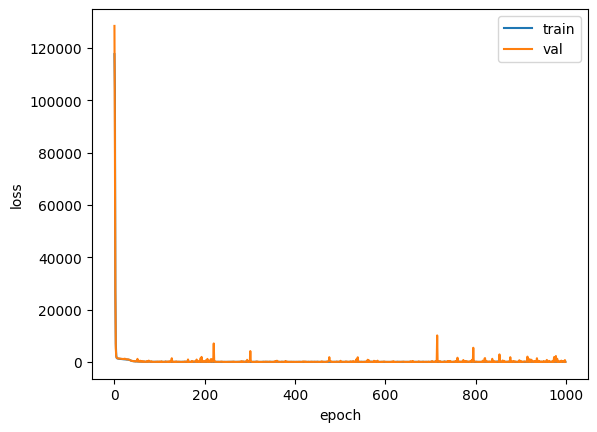

Epoch 1/1000
----------
train Loss: 121751.4787
val Loss: 129116.7875

Epoch 2/1000
----------
train Loss: 109436.5467
val Loss: 85241.6888

Epoch 3/1000
----------
train Loss: 39926.8473
val Loss: 35744.6175

Epoch 4/1000
----------
train Loss: 15991.4918
val Loss: 11465.0072

Epoch 5/1000
----------
train Loss: 4744.8177
val Loss: 3001.9794

Epoch 6/1000
----------
train Loss: 1695.2060
val Loss: 1804.4860

Epoch 7/1000
----------
train Loss: 1389.9602
val Loss: 1565.6227

Epoch 8/1000
----------
train Loss: 1301.1457
val Loss: 1523.2442

Epoch 9/1000
----------
train Loss: 1261.3132
val Loss: 1454.5656

Epoch 10/1000
----------
train Loss: 1233.4821
val Loss: 1430.1916

Epoch 11/1000
----------
train Loss: 1213.2588
val Loss: 1396.6644

Epoch 12/1000
----------
train Loss: 1192.0190
val Loss: 1392.0447

Epoch 13/1000
----------
train Loss: 1176.6971
val Loss: 1371.9406

Epoch 14/1000
----------
train Loss: 1161.2713
val Loss: 1343.7953

Epoch 15/1000
----------
train Loss: 1140.1988

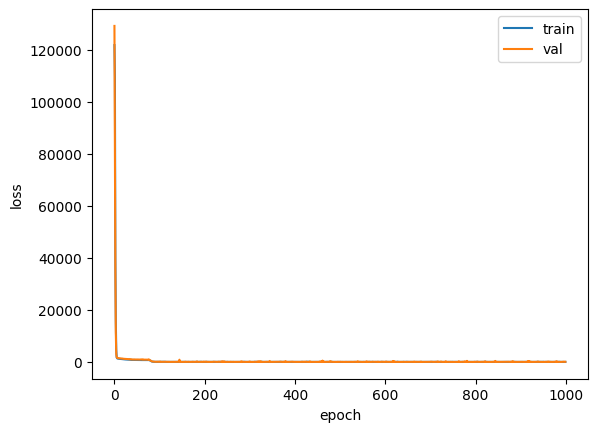

In [10]:
for dataT in ['mixed', 'normal']:
    args.data_type = dataT
    train_set, train_loader = data_provider(args, 'train')
    train_c_set, train_c_loader = data_provider(args, 'train_c')
    valid_set, valid_loader = data_provider(args, 'valid')
    test_set, test_loader = data_provider(args, 'test')
    total_set, total_loader = data_provider(args, 'pred')
    
    if args.data == '3D/new':
        for phase in ['before', 'initial', 'final']:
            phase2len = {'before':96, 'initial':352, 'final':2240}
            args.seq_len = phase2len[phase]
            for chT in ['Rmi', 'Vmi', 'Wmi', 'Accm', 'Ang', 'Fout', 'Fcmd']:
                ch = {'Rmi':3, 'Vmi':3, 'Wmi':3, 'Accm':3, 'Ang':3, 'Fout':4, 'Fcmd':4}
                args.input_channel = ch[chT]
                model = TrAE(ConvEncoder, ConvDecoder, args).to(args.device)
                criterion = nn.MSELoss()
                optimizer = optim.Adam(model.parameters(), lr=args.lr)
                scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)

                data_loaders = {'train': train_loader, 'val': valid_loader, 'test': test_loader}
                trained_model, best_model_wts, train_loss_history, val_loss_history = AE_train(model, 
                                                                                               data_loaders, 
                                                                                               criterion, 
                                                                                               optimizer, 
                                                                                               scheduler, 
                                                                                               num_epochs=args.train_epochs, 
                                                                                               channel_type = chT, 
                                                                                               phase = phase)
                torch.save(trained_model.state_dict(), args.checkpoints+args.data+args.model+'_'+args.data_type+'_'+chT+'_'+phase+'_model.pth')
                torch.save(trained_model.encoder.state_dict(), args.checkpoints+args.data+args.model+'_'+args.data_type+'_'+chT+'_'+phase+'_model_e.pth')
                trained_model.load_state_dict(best_model_wts)
                torch.save(trained_model.state_dict(), args.checkpoints+args.data+args.model+'_'+args.data_type+'_'+chT+'_'+phase+'_best_model.pth')
                torch.save(trained_model.encoder.state_dict(), args.checkpoints+args.data+args.model+'_'+args.data_type+'_'+chT+'_'+phase+'_best_model_e.pth')
                print('model saved to %s' % args.checkpoints+args.data+args.model+'_'+args.data_type+'_'+chT+'_'+phase+'_model')
                
                plt.plot(train_loss_history, label='train')
                plt.plot(val_loss_history, label='val')
                plt.xlabel('epoch')
                plt.ylabel('loss')
                plt.legend()
                plt.show()
    else:
        model = TrAE(ConvEncoder, ConvDecoder, args).to(args.device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=args.lr)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)

        data_loaders = {'train': train_loader, 'val': valid_loader, 'test': test_loader}
        trained_model, best_model_wts, train_loss_history, val_loss_history = AE_train(model, 
                                                                                       data_loaders, 
                                                                                       criterion, 
                                                                                       optimizer, 
                                                                                       scheduler, 
                                                                                       num_epochs=args.train_epochs)
        torch.save(trained_model.state_dict(), args.checkpoints+args.data+args.model+'_'+args.data_type+'_model.pth')
        torch.save(trained_model.encoder.state_dict(), args.checkpoints+args.data+args.model+'_'+args.data_type+'_model_e.pth')
        trained_model.load_state_dict(best_model_wts)
        torch.save(trained_model.state_dict(), args.checkpoints+args.data+args.model+'_'+args.data_type+'_best_model.pth')
        torch.save(trained_model.encoder.state_dict(), args.checkpoints+args.data+args.model+'_'+args.data_type+'_best_model_e.pth')
        print('model saved to %s' % args.checkpoints+args.data+args.model+'_'+args.data_type+'_model')
        
        plt.plot(train_loss_history, label='train')
        plt.plot(val_loss_history, label='val')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.show()

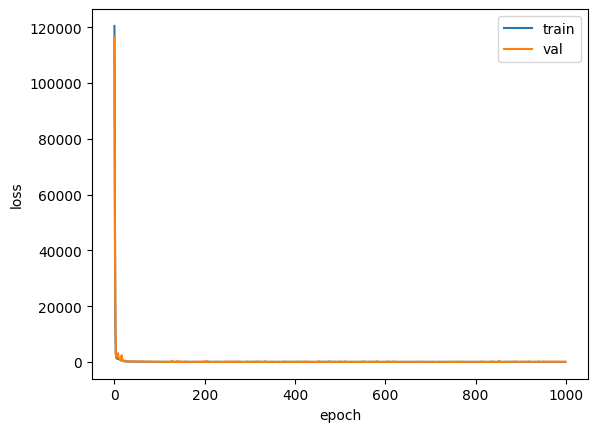

In [37]:
# Let's draw a learning curve like below.
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## Test Script

5416.583359375


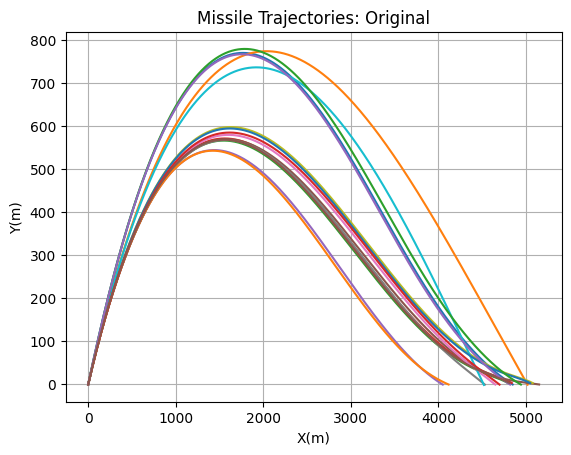

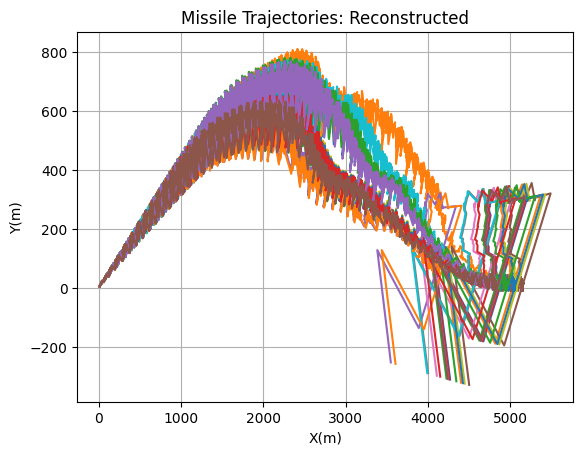

In [5]:

with torch.no_grad():
    running_loss = 0.0
    for inputs, labels in test_loader:
        inputs = inputs.to(args.device)[:,:,:2].type(torch.float32).transpose(1, 2)

        # outputs, encoded = trained_model(inputs)
        outputs, encoded = model(inputs)
        test_loss = criterion(outputs, inputs)
        
        running_loss += test_loss.item() * inputs.size(0)

    test_loss = running_loss / len(test_loader.dataset)
    print(test_loss)

tr = inputs.cpu().numpy()
tr_hat = outputs.cpu().numpy()

for n in range(len(tr)):
    plt.plot(tr[n, 0, :], tr[n, 1, :])
plt.title(f'Missile Trajectories: Original')
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.grid('minor')
plt.show()
for n in range(len(tr_hat)):
    plt.plot(tr_hat[n, 0, :], tr_hat[n, 1, :])
plt.title(f'Missile Trajectories: Reconstructed')
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.grid('minor')
plt.show()

1867.878232421875


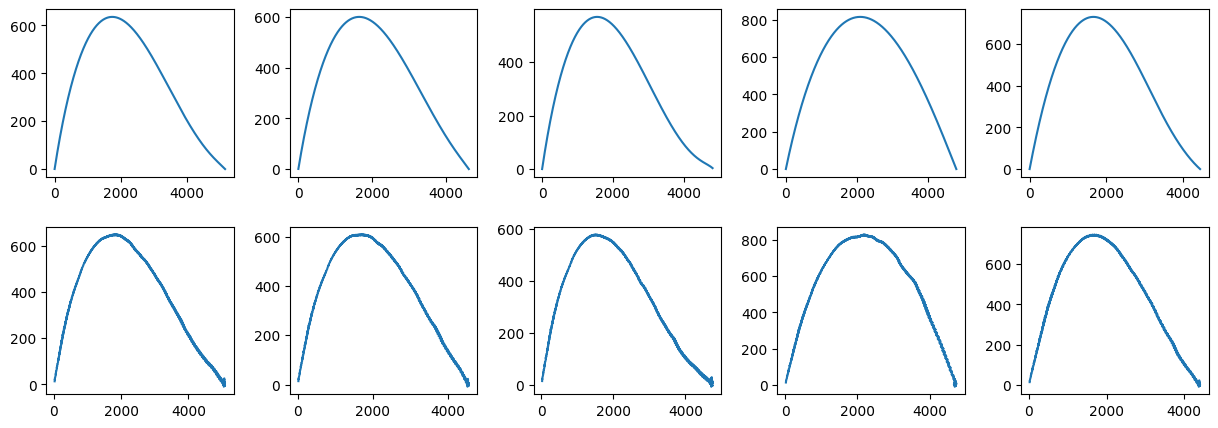

33.70838371276855


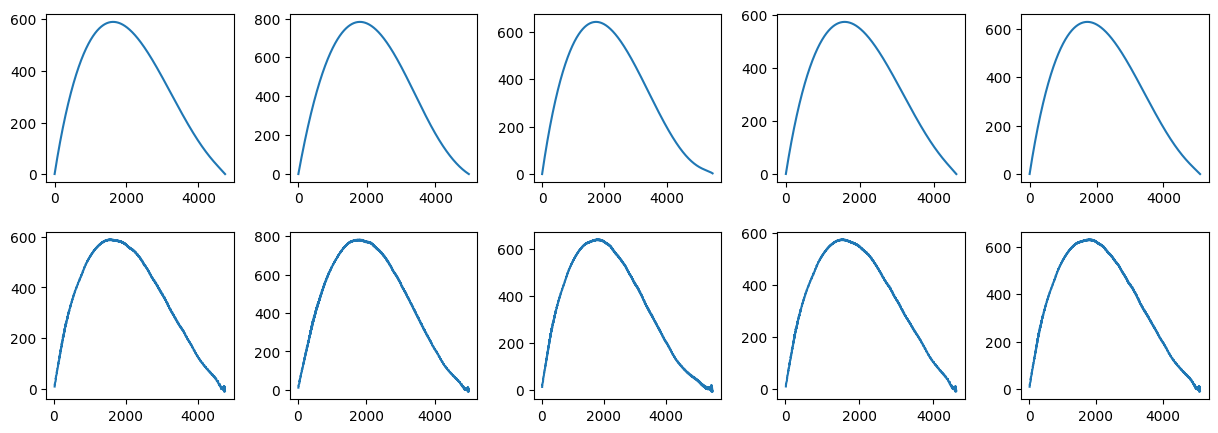

2945.744833984375


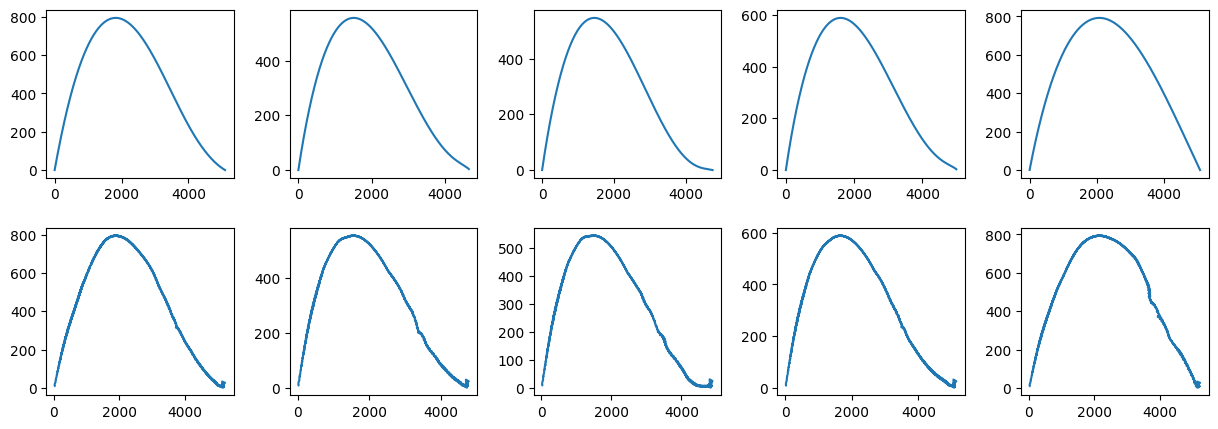

406.1973760986328


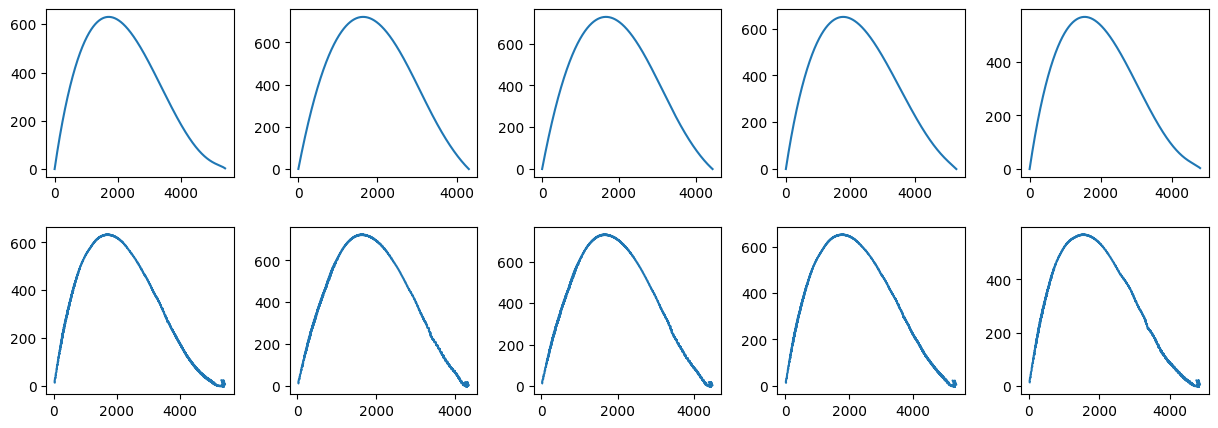

In [11]:
for dataT in ['mixed', 'normal']:
    # if dataT == 'normal':
    #     continue
    for modelT in ['model', 'best_model']:
        model.load_state_dict(torch.load(args.checkpoints+args.data+f'{args.model}_{dataT}_{modelT}.pth'))
        
        with torch.no_grad():
            running_loss = 0.0
            for inputs, labels in data_loaders["test"]:
                inputs = inputs.to(args.device)[:,:,:2].type(torch.float32).transpose(1, 2)

                # outputs, encoded = trained_model(inputs)
                outputs, encoded = model(inputs)
                test_loss = criterion(outputs, inputs)
                
                running_loss += test_loss.item() * inputs.size(0)

            test_loss = running_loss / len(data_loaders["test"].dataset)
            print(test_loss)

        tr = inputs.cpu().numpy()
        tr_hat = outputs.cpu().numpy()

        f, axes = plt.subplots(2, 5)
        f.set_size_inches((15, 5))
        plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

        for i, n in enumerate(range(0, len(tr)-1, len(tr)//5)):
            axes[0, i].plot(tr[n, 0, :], tr[n, 1, :])
            # axes[0, i].plot(tr[n, 0, :])
            # axes[0, i].plot(tr[n, 1, :])
            axes[1, i].plot(tr_hat[n, 0, :], tr_hat[n, 1, :])
            # axes[1, i].plot(tr_hat[n, 0, :])
            # axes[1, i].plot(tr_hat[n, 1, :])

        plt.show()

## Trajectory Visualizing

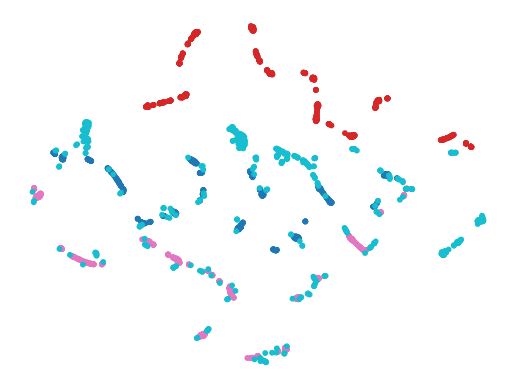

In [39]:
np.random.seed(42)

from sklearn.manifold import TSNE

dataset_array = total_set.data_x / 255
dataset_array = np.float32(dataset_array)
labels = total_set.data_y

dataset_array = torch.tensor(dataset_array)
inputs = dataset_array.to(args.device)[:,:,:2].type(torch.float32).transpose(1, 2)
outputs, encoded = trained_model(inputs)

encoded = encoded.cpu().detach().numpy().reshape(encoded.size(0), -1)
tsne = TSNE()   
X_test_2D = tsne.fit_transform(encoded)
X_test_2D = (X_test_2D - X_test_2D.min()) / (X_test_2D.max() - X_test_2D.min())

plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=labels, s=10, cmap="tab10")
plt.axis("off")
plt.show()

In [57]:
encoder = ConvEncoder(args.input_channel, args.t, args.output_channel)
encoder.load_state_dict(torch.load(args.checkpoints+args.data+f'{args.model}_{args.data_type}_model_e.pth'))
encoder = encoder.to(args.device)
classifier = Classifier(args.seq_len//(2**args.layer_num)*args.class_num, args.class_num).to(args.device)
classifier_lossf = nn.MSELoss()
# classifier_lossf = nn.CrossEntropyLoss()
classifier_optim = optim.Adam(classifier.parameters(), lr=args.lr)

In [12]:
def AC_train(encoder, classifier, dataloaders, criterion, optimizer, scheduler, num_epochs=10, channels = 2, channel_type = None, lossf = None):
    """
    model: model to train
    dataloaders: train, val, test data's loader
    criterion: loss function
    optimizer: optimizer to update your model
    """
    # if phase == 'before':
    #     tl = 0
    # elif phase == 'initial':
    #     tl = 80
    # elif phase == 'final':
    #     tl = 411
    # else:
    #     tl = 0
    #     phase = 'whole'
    # tr = tl + args.seq_len
    
    # if channel_type == None:
    #     cl = 0
    # elif channel_type == 'Rmi':
    #     cl = 0
    # elif channel_type == 'Vmi':
    #     cl = 3
    # elif channel_type == 'Wmb':
    #     cl = 6
    # elif channel_type == 'Accm':
    #     cl = 9
    # elif channel_type == 'ang':
    #     cl = 12
    # elif channel_type == 'Fout':
    #     cl = 15
    # elif channel_type == 'Fcmd':
    #     cl = 19
    # cr = cl + channels

    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(classifier.state_dict())
    best_val_loss = 100000000

    since = time.time()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            encoder.eval()
            if phase == 'train':
                classifier.train()            # Set model to training mode
            else:
                classifier.eval()            # Set model to evaluate mode

            running_loss = 0.0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # inputs = inputs.to(args.device)[:,tl:tr,cl:cr].type(torch.float32).transpose(1, 2)
                inputs = inputs.to(args.device)[:,:,:2].type(torch.float32).transpose(1, 2)
                labels = F.one_hot(labels, num_classes=4).to(args.device).type(torch.float32)
                optimizer.zero_grad()
                
                with torch.no_grad():
                    hidden = encoder(inputs)
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = classifier(hidden.reshape(hidden.size(0), -1)).type(torch.float32)
                    loss = criterion(outputs.view(-1), labels.view(-1))
                    # loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        # loss.requires_grad = True
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                running_loss += loss.item()        
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            # deep copy the model
            if phase == 'train':
                train_loss_history.append(epoch_loss)
            if phase == 'val':
                val_loss_history.append(epoch_loss)
            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(classifier.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_val_loss))

    # load best model weights
    # classifier.load_state_dict(best_model_wts)
    return classifier, best_model_wts, train_loss_history, val_loss_history

In [6]:
def Ctrain(encoder, model, Loss, optimizer, scheduler, num_epochs, phase = None, channel_type = None):
    if phase == 'before':
        tl = 0
    elif phase == 'initial':
        tl = 80
    elif phase == 'final':
        tl = 411
    else:
        tl = 0
        phase = 'whole'
    tr = tl + args.seq_len
    
    if channel_type == 'Rmi':
        cl = 0
    elif channel_type == 'Vmi':
        cl = 3
    elif channel_type == 'Wmb':
        cl = 6
    elif channel_type == 'Accm':
        cl = 9
    elif channel_type == 'ang':
        cl = 12
    elif channel_type == 'Fout':
        cl = 15
    elif channel_type == 'Fcmd':
        cl = 19
    else:
        cl = 0
        channel_type = 'position'
    cr = cl + args.input_channel
    
    print(f'{phase} phase {channel_type} data model training Start')
    
    train_loss_arr = []
    val_loss_arr = []

    best_val_loss = 99999999
    encoder.eval()
    for epoch in tqdm(range(num_epochs), total=num_epochs, desc=f'Training', ncols=70):

        epoch_loss = 0.
        for batch_X, labels in train_loader:
            batch_X = batch_X.to(args.device)[:,:,:2].type(torch.float32).transpose(1, 2)
            labels = F.one_hot(labels, num_classes=4).to(args.device).type(torch.float32)
            hidden_X = encoder(batch_X)
            optimizer.zero_grad()

            # Forward Pass
            model.train()
            preds = model(hidden_X.reshape(hidden_X.size(0), -1))
            train_loss = Loss(preds, labels)
            epoch_loss += train_loss.data

            # Backward and optimize
            train_loss.backward()
            optimizer.step()
            scheduler.step()

        train_loss_arr.append((epoch_loss.item() / len(train_loader.dataset))/args.seq_len)

        model.eval()
        val_loss = 0.
        for batch_X, labels in valid_loader:
            batch_X = batch_X.to(args.device)[:,:,:2].type(torch.float32).transpose(1, 2)
            labels = F.one_hot(labels, num_classes=4).to(args.device).type(torch.float32)
            hidden_X = encoder(batch_X)

            # Forward Pass
            preds = model(hidden_X.reshape(hidden_X.size(0), -1))
            batch_loss = Loss(preds, labels)
            val_loss += batch_loss.data

        val_loss_arr.append((val_loss.item() / len(train_loader.dataset))/args.seq_len)

        if best_val_loss > val_loss:
            best_val_loss = val_loss
            # best_model_wts = copy.deepcopy(model.module.state_dict())
            best_model_wts = copy.deepcopy(model.state_dict())
    print('Train Loss: {:.4f}, Valid Loss: {:.4f}, Best Valid Loss: {:.4f}'.format(epoch_loss/args.seq_len, val_loss/args.seq_len, best_val_loss/args.seq_len))
    return model, best_model_wts, train_loss_arr, val_loss_arr

whole phase position data model training Start


Training: 100%|███████████████████| 1000/1000 [19:37<00:00,  1.18s/it]

Train Loss: 0.0011, Valid Loss: 0.0004, Best Valid Loss: 0.0000
model saved to ./checkpoints/2D/MSE_3L_A_mixed_model_c


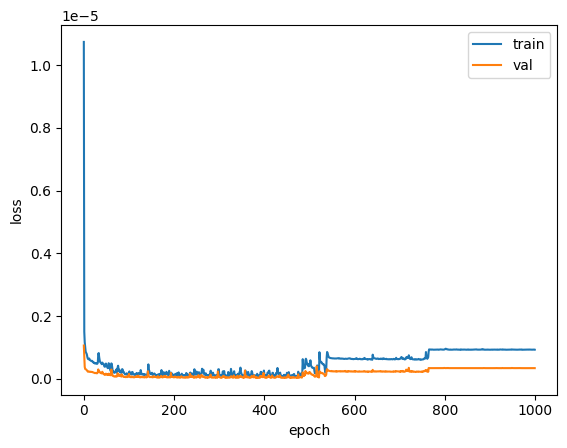

whole phase position data model training Start


Training: 100%|███████████████████| 1000/1000 [19:07<00:00,  1.15s/it]

Train Loss: 0.0005, Valid Loss: 0.0003, Best Valid Loss: 0.0001
model saved to ./checkpoints/2D/CE_3L_A_mixed_model_c


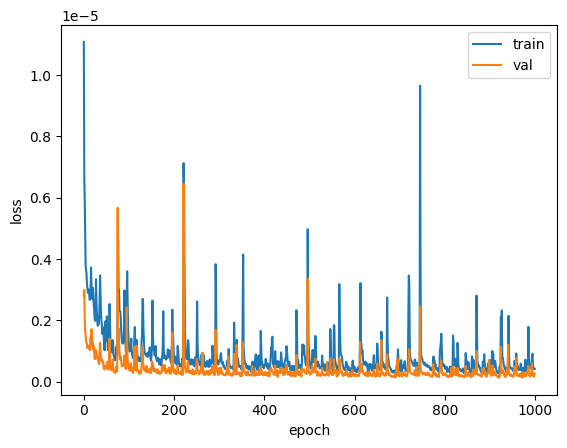

whole phase position data model training Start


Training: 100%|███████████████████| 1000/1000 [19:27<00:00,  1.17s/it]

Train Loss: 0.0000, Valid Loss: 0.0008, Best Valid Loss: 0.0007
model saved to ./checkpoints/2D/MSE_3L_A_normal_model_c


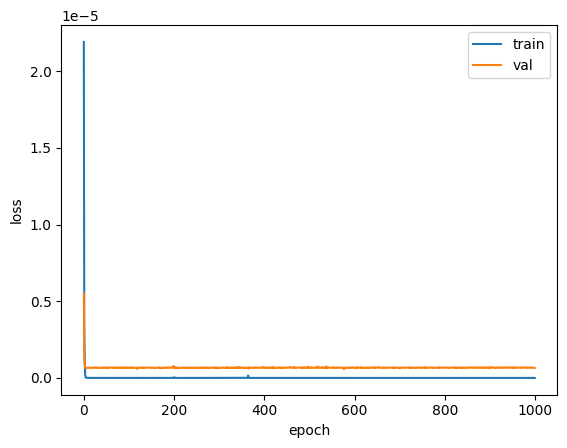

whole phase position data model training Start


Training: 100%|███████████████████| 1000/1000 [19:09<00:00,  1.15s/it]

Train Loss: 0.0000, Valid Loss: 0.2368, Best Valid Loss: 0.1863
model saved to ./checkpoints/2D/CE_3L_A_normal_model_c


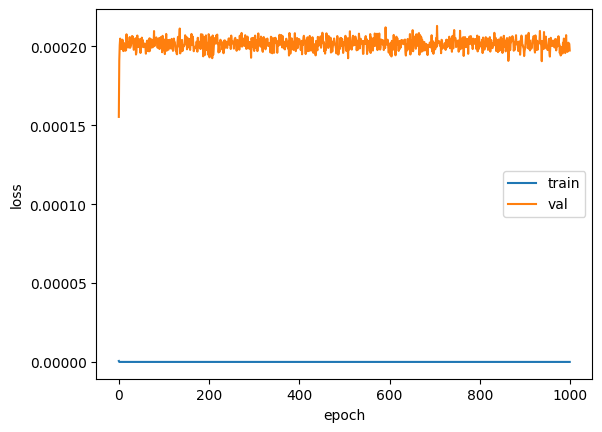

In [7]:
for dataT in ['mixed', 'normal']:
    # if dataT == 'normal':
    #     continue
    args.data_type = dataT
    
    train_set, train_loader = data_provider(args, 'train')
    train_c_set, train_c_loader = data_provider(args, 'train_c')
    valid_set, valid_loader = data_provider(args, 'valid')
    test_set, test_loader = data_provider(args, 'test')
    total_set, total_loader = data_provider(args, 'pred')
        
    if args.data == '3D/new':
        for phase in ['before', 'initial', 'final']:
            for chT in ['Rmi', 'Vmi', 'Wmi', 'Accm', 'Ang', 'Fout', 'Fcmd']:
                ch = {'Rmi':3, 'Vmi':3, 'Wmi':3, 'Accm':3, 'Ang':3, 'Fout':4, 'Fcmd':4}
                args.input_channel = ch[chT]
        
                for lossf in ['MSE', 'CE']:
                    # if lossf == 'MSE':
                    #     continue
                    if lossf == 'MSE':
                        classifier_lossf = nn.MSELoss()
                    elif lossf == 'CE':
                        classifier_lossf = nn.CrossEntropyLoss()
                    encoder = ConvEncoder(args.input_channel, args.t, args.output_channel)
                    encoder.load_state_dict(torch.load(args.checkpoints+args.data+args.model+'_'+args.data_type+'_'+chT+'_'+phase+'_model_e.pth'))
                    encoder = encoder.to(args.device)
                    classifier = Classifier(args.seq_len//(2**(args.layer_num-1))*args.class_num, args.class_num).to(args.device)
                    classifier_optim = optim.Adam(classifier.parameters(), lr=args.lr)
                    classifier_scheduler = optim.lr_scheduler.CosineAnnealingLR(classifier_optim, T_max=10, eta_min=1e-5)

                    data_loaders = {'train': train_c_loader, 'val': valid_loader, 'test': test_loader}
                    trained_classifier, best_classifier_wts, train_loss_history, val_loss_history = Ctrain(encoder, classifier, classifier_lossf, classifier_optim, classifier_scheduler, args.train_epochs, phase, chT)
                    torch.save(trained_classifier.state_dict(), args.checkpoints+args.data+lossf+'_3L_'+args.model+'_'+args.data_type+'_'+chT+'_'+phase+'_model_c.pth')
                    torch.save(best_classifier_wts, args.checkpoints+args.data+lossf+'_3L_'+args.model+'_'+args.data_type+'_'+chT+'_'+phase+'_best_model_c.pth')
                    print('model saved to %s' % args.checkpoints+args.data+lossf+'_3L_'+args.model+'_'+args.data_type+'_'+chT+'_'+phase+'_model_c')
                    
                    # Let's draw a learning curve like below.
                    plt.plot(train_loss_history, label='train')
                    plt.plot(val_loss_history, label='val')
                    plt.xlabel('epoch')
                    plt.ylabel('loss')
                    plt.legend()
                    plt.show() 
    else:
        for lossf in ['MSE', 'CE']:
            # if lossf == 'MSE':
            #     continue
            if lossf == 'MSE':
                classifier_lossf = nn.MSELoss()
            elif lossf == 'CE':
                classifier_lossf = nn.CrossEntropyLoss()
            encoder = ConvEncoder(args.input_channel, args.t, args.output_channel)
            encoder.load_state_dict(torch.load(args.checkpoints+args.data+args.model+'_'+args.data_type+'_model_e.pth'))
            encoder = encoder.to(args.device)
            classifier = Classifier(args.seq_len//(2**(args.layer_num-1))*args.class_num, args.class_num).to(args.device)
            classifier_optim = optim.Adam(classifier.parameters(), lr=args.lr)
            classifier_scheduler = optim.lr_scheduler.CosineAnnealingLR(classifier_optim, T_max=10, eta_min=1e-5)

            data_loaders = {'train': train_c_loader, 'val': valid_loader, 'test': test_loader}
            trained_classifier, best_classifier_wts, train_loss_history, val_loss_history = Ctrain(encoder, classifier, classifier_lossf, classifier_optim, classifier_scheduler, args.train_epochs)
            torch.save(trained_classifier.state_dict(), args.checkpoints+args.data+lossf+'_3L_'+args.model+'_'+args.data_type+'_model_c.pth')
            torch.save(best_classifier_wts, args.checkpoints+args.data+lossf+'_3L_'+args.model+'_'+args.data_type+'_best_model_c.pth')
            print('model saved to %s' % args.checkpoints+args.data+lossf+'_3L_'+args.model+'_'+args.data_type+'_model_c')
            
            # Let's draw a learning curve like below.
            plt.plot(train_loss_history, label='train')
            plt.plot(val_loss_history, label='val')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.legend()
            plt.show() 

In [ ]:
output, hidden = TrAE(ConvEncoder, ConvDecoder, args)(next(iter(data_loaders['train']))[0][:,:,:2].transpose(1, 2).type(torch.float32))
pred = Classifier(args.seq_len//(2**args.layer_num)*args.class_num, args.class_num)(hidden.reshape(hidden.size(0), -1))
F.softmax(pred, dim=1)
# pred

Epoch 1/500
----------
train Loss: 0.0098
val Loss: 0.0044

Epoch 2/500
----------
train Loss: 0.0031
val Loss: 0.0035

Epoch 3/500
----------
train Loss: 0.0030
val Loss: 0.0037

Epoch 4/500
----------
train Loss: 0.0030
val Loss: 0.0031

Epoch 5/500
----------
train Loss: 0.0028
val Loss: 0.0030

Epoch 6/500
----------
train Loss: 0.0026
val Loss: 0.0028

Epoch 7/500
----------
train Loss: 0.0024
val Loss: 0.0026

Epoch 8/500
----------
train Loss: 0.0023
val Loss: 0.0025

Epoch 9/500
----------
train Loss: 0.0022
val Loss: 0.0023

Epoch 10/500
----------
train Loss: 0.0021
val Loss: 0.0023

Epoch 11/500
----------
train Loss: 0.0021
val Loss: 0.0022

Epoch 12/500
----------
train Loss: 0.0021
val Loss: 0.0022

Epoch 13/500
----------
train Loss: 0.0021
val Loss: 0.0023

Epoch 14/500
----------
train Loss: 0.0020
val Loss: 0.0022

Epoch 15/500
----------
train Loss: 0.0020
val Loss: 0.0021

Epoch 16/500
----------
train Loss: 0.0019
val Loss: 0.0022

Epoch 17/500
----------
train Los

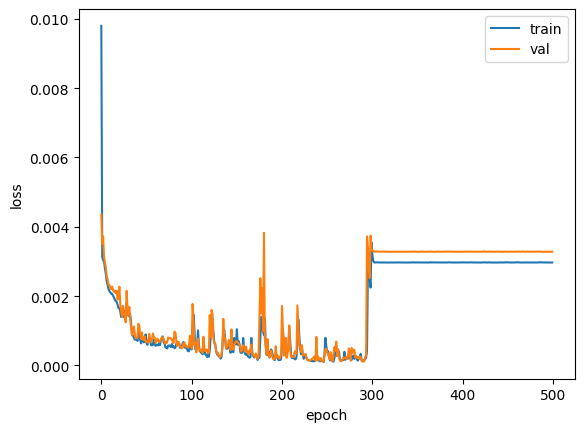

Epoch 1/500
----------
train Loss: 5.8226
val Loss: 5.4882

Epoch 2/500
----------
train Loss: 5.5143
val Loss: 5.4643

Epoch 3/500
----------
train Loss: 5.5042
val Loss: 5.4462

Epoch 4/500
----------
train Loss: 5.3958
val Loss: 5.3191

Epoch 5/500
----------
train Loss: 5.2669
val Loss: 5.1451

Epoch 6/500
----------
train Loss: 5.1078
val Loss: 5.0202

Epoch 7/500
----------
train Loss: 5.0491
val Loss: 4.9210

Epoch 8/500
----------
train Loss: 5.0343
val Loss: 4.9110

Epoch 9/500
----------
train Loss: 4.9165
val Loss: 4.8333

Epoch 10/500
----------
train Loss: 4.8510
val Loss: 4.7747

Epoch 11/500
----------
train Loss: 4.8136
val Loss: 4.7341

Epoch 12/500
----------
train Loss: 4.7596
val Loss: 4.7075

Epoch 13/500
----------
train Loss: 4.7787
val Loss: 4.8269

Epoch 14/500
----------
train Loss: 4.8153
val Loss: 4.7036

Epoch 15/500
----------
train Loss: 4.7219
val Loss: 4.7992

Epoch 16/500
----------
train Loss: 4.7271
val Loss: 4.6843

Epoch 17/500
----------
train Los

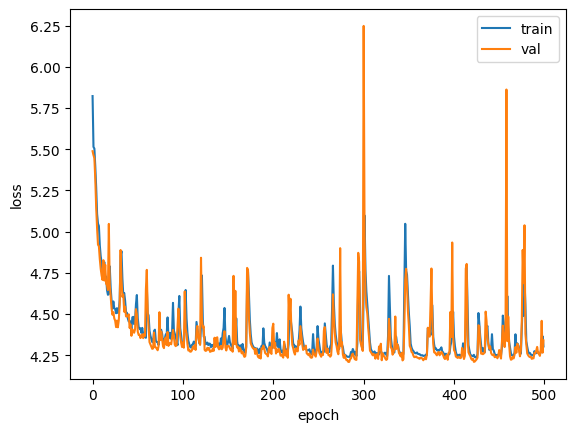

Epoch 1/500
----------
train Loss: 0.0485
val Loss: 0.0209

Epoch 2/500
----------
train Loss: 0.0067
val Loss: 0.0084

Epoch 3/500
----------
train Loss: 0.0041
val Loss: 0.0043

Epoch 4/500
----------
train Loss: 0.0034
val Loss: 0.0036

Epoch 5/500
----------
train Loss: 0.0030
val Loss: 0.0030

Epoch 6/500
----------
train Loss: 0.0026
val Loss: 0.0027

Epoch 7/500
----------
train Loss: 0.0024
val Loss: 0.0025

Epoch 8/500
----------
train Loss: 0.0023
val Loss: 0.0025

Epoch 9/500
----------
train Loss: 0.0022
val Loss: 0.0024

Epoch 10/500
----------
train Loss: 0.0021
val Loss: 0.0023

Epoch 11/500
----------
train Loss: 0.0021
val Loss: 0.0023

Epoch 12/500
----------
train Loss: 0.0020
val Loss: 0.0022

Epoch 13/500
----------
train Loss: 0.0019
val Loss: 0.0022

Epoch 14/500
----------
train Loss: 0.0020
val Loss: 0.0022

Epoch 15/500
----------
train Loss: 0.0020
val Loss: 0.0022

Epoch 16/500
----------
train Loss: 0.0020
val Loss: 0.0021

Epoch 17/500
----------
train Los

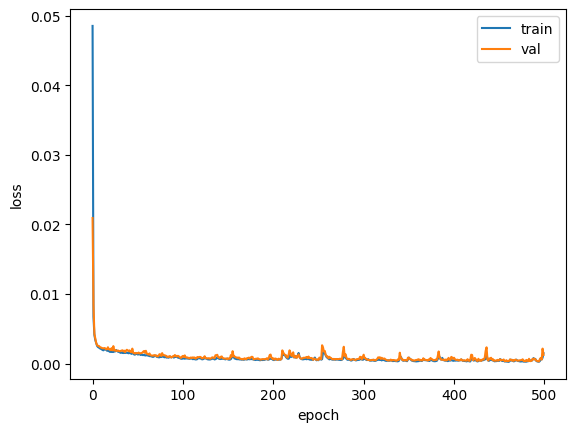

Epoch 1/500
----------
train Loss: 6.3462
val Loss: 5.7925

Epoch 2/500
----------
train Loss: 5.4239
val Loss: 5.2784

Epoch 3/500
----------
train Loss: 5.2044
val Loss: 5.2264

Epoch 4/500
----------
train Loss: 5.1524
val Loss: 5.0492

Epoch 5/500
----------
train Loss: 5.0817
val Loss: 4.9814

Epoch 6/500
----------
train Loss: 5.0459
val Loss: 4.9633

Epoch 7/500
----------
train Loss: 4.9725
val Loss: 4.8752

Epoch 8/500
----------
train Loss: 4.9240
val Loss: 4.8740

Epoch 9/500
----------
train Loss: 4.9164
val Loss: 4.8286

Epoch 10/500
----------
train Loss: 4.9252
val Loss: 4.8406

Epoch 11/500
----------
train Loss: 4.8548
val Loss: 4.7944

Epoch 12/500
----------
train Loss: 4.8432
val Loss: 4.7858

Epoch 13/500
----------
train Loss: 4.7999
val Loss: 4.8532

Epoch 14/500
----------
train Loss: 4.8226
val Loss: 4.7664

Epoch 15/500
----------
train Loss: 4.7664
val Loss: 4.7868

Epoch 16/500
----------
train Loss: 4.7644
val Loss: 4.7735

Epoch 17/500
----------
train Los

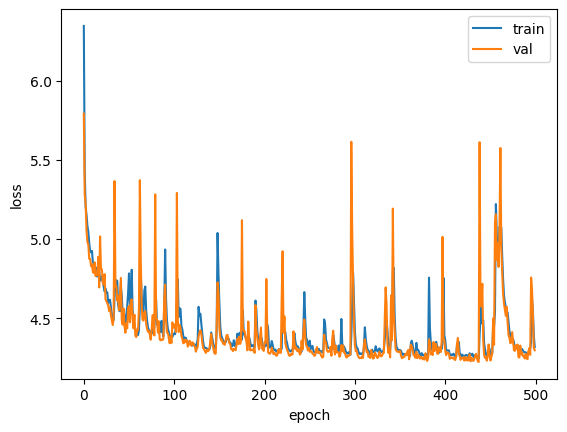

In [13]:
for dataT in ['mixed', 'normal']:
    # if dataT == 'normal':
    #     continue
    args.data_type = dataT
    
    train_set, train_loader = data_provider(args, 'train')
    train_c_set, train_c_loader = data_provider(args, 'train_c')
    valid_set, valid_loader = data_provider(args, 'valid')
    test_set, test_loader = data_provider(args, 'test')
    total_set, total_loader = data_provider(args, 'pred')
    
    if args.data == '3D/new':
        for chT in ['Rmi', 'Vmi', 'Wmi', 'Accm', 'Ang', 'Fout', 'Fcmd']:
            ch = {'Rmi':3, 'Vmi':3, 'Wmi':3, 'Accm':3, 'Ang':3, 'Fout':4, 'Fcmd':4}
            args.input_channel = ch[chT]
    
            for lossf in ['MSE', 'CE']:
                # if lossf == 'MSE':
                #     continue
                if lossf == 'MSE':
                    classifier_lossf = nn.MSELoss().to(args.device)
                elif lossf == 'CE':
                    classifier_lossf = nn.CrossEntropyLoss().to(args.device)
                encoder = ConvEncoder(args.input_channel, args.t, args.output_channel)
                encoder.load_state_dict(torch.load(args.checkpoints+args.data+f'{args.model}_{args.data_type}_{chT}_model_e.pth'))
                encoder = encoder.to(args.device)
                classifier = Classifier(args.seq_len//(2**args.layer_num)*args.class_num, args.class_num).to(args.device)
                classifier_optim = optim.Adam(classifier.parameters(), lr=args.lr)
                classifier_scheduler = optim.lr_scheduler.CosineAnnealingLR(classifier_optim, T_max=10, eta_min=1e-5)

                data_loaders = {'train': train_c_loader, 'val': valid_loader, 'test': test_loader}
                trained_classifier, best_classifier_wts, train_loss_history, val_loss_history = AC_train(encoder, classifier, data_loaders, classifier_lossf, classifier_optim, classifier_scheduler, num_epochs=500, channels=args.input_channel, channel_type=chT, lossf=lossf) # args.train_epochs
                torch.save(trained_classifier.state_dict(), args.checkpoints+args.data+lossf+'_3L_'+args.model+'_'+args.data_type+'_'+chT+'_model_c.pth')
                torch.save(best_classifier_wts, args.checkpoints+args.data+lossf+'_3L_'+args.model+'_'+args.data_type+'_'+chT+'_best_model_c.pth')
                print('model saved to %s' % args.checkpoints+args.data+lossf+'_3L_'+args.model+'_'+args.data_type+'_'+chT+'_model_c')
                
                # Let's draw a learning curve like below.
                plt.plot(train_loss_history, label='train')
                plt.plot(val_loss_history, label='val')
                plt.xlabel('epoch')
                plt.ylabel('loss')
                plt.legend()
                plt.show() 
    else:
        for lossf in ['MSE', 'CE']:
            # if lossf == 'MSE':
            #     continue
            if lossf == 'MSE':
                classifier_lossf = nn.MSELoss().to(args.device)
            elif lossf == 'CE':
                classifier_lossf = nn.CrossEntropyLoss().to(args.device)
            encoder = ConvEncoder(args.input_channel, args.t, args.output_channel)
            encoder.load_state_dict(torch.load(args.checkpoints+args.data+f'{args.model}_{args.data_type}_model_e.pth'))
            encoder = encoder.to(args.device)
            classifier = Classifier(args.seq_len//(2**(args.layer_num-1))*args.class_num, args.class_num).to(args.device)
            classifier_optim = optim.Adam(classifier.parameters(), lr=args.lr)
            classifier_scheduler = optim.lr_scheduler.CosineAnnealingLR(classifier_optim, T_max=10, eta_min=1e-5)

            data_loaders = {'train': train_c_loader, 'val': valid_loader, 'test': test_loader}
            trained_classifier, best_classifier_wts, train_loss_history, val_loss_history = AC_train(encoder, classifier, data_loaders, classifier_lossf, classifier_optim, classifier_scheduler, num_epochs=500, lossf=lossf) # epochs = args.train_epochs
            torch.save(trained_classifier.state_dict(), args.checkpoints+args.data+lossf+'_3L_'+args.model+'_'+args.data_type+'_model_c.pth')
            torch.save(best_classifier_wts, args.checkpoints+args.data+lossf+'_3L_'+args.model+'_'+args.data_type+'_best_model_c.pth')
            print('model saved to %s' % args.checkpoints+args.data+lossf+'_3L_'+args.model+'_'+args.data_type+'_model_c')
            
            # Let's draw a learning curve like below.
            plt.plot(train_loss_history, label='train')
            plt.plot(val_loss_history, label='val')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.legend()
            plt.show() 

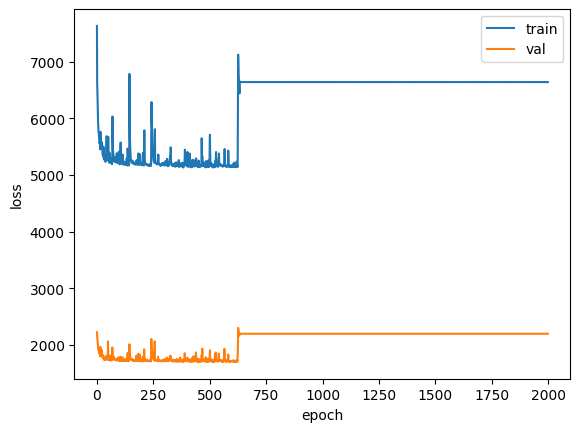

In [7]:
# Let's draw a learning curve like below.
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
lossF = 'MSE'
layerN = 3
modelt = 'A'
dtype = 'normal'
paramT = 'best_model'

# trained_classifier = Classifier(args.seq_len//(2**args.layer_num)*args.class_num, args.class_num).to(args.device)
encoder.load_state_dict(torch.load(args.checkpoints+args.data+f'{modelt}_{dtype}_model_e.pth'))
trained_classifier.load_state_dict(torch.load(args.checkpoints+args.data+f'{lossF}_{layerN}L_{modelt}_{dtype}_{paramT}_c.pth'))

<All keys matched successfully>

In [15]:
from sklearn.metrics import roc_auc_score, average_precision_score

for dataT in ['mixed', 'normal']:
    # if dataT == 'mixed':
    #     continue
    args.data_type = dataT
    
    train_set, train_loader = data_provider(args, 'train')
    train_c_set, train_c_loader = data_provider(args, 'train_c')
    valid_set, valid_loader = data_provider(args, 'valid')
    test_set, test_loader = data_provider(args, 'test')
    total_set, total_loader = data_provider(args, 'pred')
    
    for modelT in ['model', 'best_model']:
        for lossf in ['MSE', 'CE']:
            # if lossf == 'MSE':
            #     continue
            
            data_loaders = {'train': train_c_loader, 'val': valid_loader, 'test': test_loader}
            encoder = ConvEncoder(args.input_channel, args.t, args.output_channel)
            encoder.load_state_dict(torch.load(args.checkpoints+args.data+f'{args.model}_{args.data_type}_model_e.pth'))
            encoder = encoder.to(args.device)
            trained_classifier = Classifier(args.seq_len//(2**(args.layer_num-1))*args.class_num, args.class_num).to(args.device)
            trained_classifier.load_state_dict(torch.load(args.checkpoints+args.data+lossf+'_3L_'+args.model+'_'+args.data_type+'_'+modelT+'_c.pth'))
            trained_classifier = trained_classifier.to(args.device)

            correct = 0
            total = 0

            with torch.no_grad():
                for inputs, labels in data_loaders["test"]:
                    inputs = inputs.to(args.device)[:,:,:2].type(torch.float32).transpose(1, 2)
                    labels_onehot = F.one_hot(labels, num_classes=4).to(args.device).type(torch.float32)
                    labels = labels.to(args.device).type(torch.float32)

                    hidden = encoder(inputs)
                    outputs = trained_classifier(hidden.reshape(hidden.size(0), -1)).type(torch.float32)
                    
                    total += labels.size(0)
                    correct += (outputs.argmax(1) == labels).sum().item()
            print(args.data_type, modelT, lossf)
            print('Accuracy:', correct/total * 100, '%')

mixed model MSE
Accuracy: 26.25 %
mixed model CE
Accuracy: 37.0 %
mixed best_model MSE
Accuracy: 44.25 %
mixed best_model CE
Accuracy: 39.25 %
normal model MSE
Accuracy: 45.0 %
normal model CE
Accuracy: 53.5 %
normal best_model MSE
Accuracy: 67.0 %
normal best_model CE
Accuracy: 37.0 %


## 1000 for AE, 2000 for C
### Mixed
3 layer
- MSE: 96
- CE: 96.75

### Normal
3 layer
- MSE: 97.25
- CE: 98.75